In [1]:
base_dir = "results/parul"
unmitigated_results_file_name = f"{base_dir}/0.05_2021-01-14_00-30-59_unmitigated.json"
fairlearn_results_file_name = f"{base_dir}/0.05_2021-01-14_00-30-59_fairlearn.json"
hybrid_results_file_name = f"{base_dir}/0.05_2021-01-14_15-58-03_hybrid.json"

In [2]:
import os
import json
import numpy as np

import numpy as np
from scipy.stats import norm, t, sem

def mean_confidence_interval(data, confidence=0.95):
    a = np.asarray(data).astype(float)
    n = len(a)
    m, se = np.nanmean(a), sem(a, nan_policy="omit", ddof=1)
    h1 = m + se * t.ppf((1.0 - confidence) / 2., n - 1)
    h2 = m + se * t.ppf((1.0 + confidence) / 2., n - 1)
    return [m, h1, h2]

with open(unmitigated_results_file_name, 'r') as _file:
    unmitigated_results = json.load(_file)

with open(fairlearn_results_file_name, 'r') as _file:
    fairlearn_results = json.load(_file)

with open(hybrid_results_file_name, 'r') as _file:
    hybrid_results = json.load(_file)

# Unmitigated results
time_unmitigated = unmitigated_results["time_unmitigated"]
error_unmitigated = unmitigated_results["error_unmitigated"]
violation_unmitigated = unmitigated_results["vio_unmitigated"]

# Fairlearn results
time_expgrad_all = fairlearn_results["time_expgrad_all"]
error_expgrad_all = fairlearn_results["error_expgrad_all"]
violation_expgrad_all = fairlearn_results["vio_expgrad_all"]

# Hybrid results
fractions = []

time_expgrad_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
time_hybrid1_ci = np.full((len(hybrid_results), 3), np.nan)
time_hybrid2_ci = np.full((len(hybrid_results), 3), np.nan)
time_hybrid3_ci = np.full((len(hybrid_results), 3), np.nan)
time_hybrid4_ci = np.full((len(hybrid_results), 3), np.nan)
time_hybrid5_ci = np.full((len(hybrid_results), 3), np.nan)
time_unmitigated_ci = np.full((len(hybrid_results), 3), np.nan)
time_expgrad_alls_ci = np.full((len(hybrid_results), 3), np.nan)

error_expgrad_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
error_hybrids_ci = np.full((len(hybrid_results), 3), np.nan)
error_expgrad_alls_ci = np.full((len(hybrid_results), 3), np.nan)
error_unmitigated_ci = np.full((len(hybrid_results), 3), np.nan)

vio_expgrad_alls_ci = np.full((len(hybrid_results), 3), np.nan)
vio_expgrad_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
vio_hybrids_ci = np.full((len(hybrid_results), 3), np.nan)
vio_unmitigated_ci = np.full((len(hybrid_results), 3), np.nan)

# Hybrid 2
# error_grid_pmf_fracs = np.full(len(hybrid_results), np.nan)
# vio_grid_pmf_fracs = np.full(len(hybrid_results), np.nan)

error_grid_pmf_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
vio_grid_pmf_fracs_ci = np.full((len(hybrid_results), 3), np.nan)

# Hybrid 3
vio_rewts_pmf_ci = np.full((len(hybrid_results), 3), np.nan)
error_rewts_pmf_ci = np.full((len(hybrid_results), 3), np.nan)

# Hybrid 4
error_rewts_partial_ci = np.full((len(hybrid_results), 3), np.nan)
vio_rewts_partial_ci = np.full((len(hybrid_results), 3), np.nan)

# Hybrid 5
error_no_grid_rewts_ci = np.full((len(hybrid_results), 3), np.nan)
vio_no_grid_rewts_ci = np.full((len(hybrid_results), 3), np.nan)

for i, r in enumerate(hybrid_results):
    f = r["frac"]
    _time_expgrad_fracs = r["_time_expgrad_fracs"]
    _time_hybrid1 = r["_time_hybrid1"]
    _time_hybrid2 = r["_time_hybrid2"]
    _time_hybrid3 = r["_time_hybrid3"]
    _time_hybrid4 = r["_time_hybrid4"]
    _time_hybrid5 = r["_time_hybrid5"]
    _error_expgrad_fracs = r["_error_expgrad_fracs"]
    _vio_expgrad_fracs = r["_vio_expgrad_fracs"]
    _error_hybrids = r["_error_hybrids"]
    _vio_hybrids = r["_vio_hybrids"]
    _error_grid_pmf_fracs = r["_error_grid_pmf_fracs"]
    _vio_grid_pmf_fracs = r["_vio_grid_pmf_fracs"]
    _error_rewts = r["_error_rewts"]
    _vio_rewts = r["_vio_rewts"]
    _error_rewts_partial = r["_error_rewts_partial"]
    _vio_rewts_partial = r["_vio_rewts_partial"]
    _error_no_grid_rewts = r["_error_no_grid_rewts"]
    _vio_no_grid_rewts = r["_vio_no_grid_rewts"]

    fractions.append(f)
    
    time_expgrad_alls_ci[i] = mean_confidence_interval(time_expgrad_all)
    time_unmitigated_ci[i] = mean_confidence_interval(time_unmitigated)
    
    error_expgrad_alls_ci[i] = mean_confidence_interval(error_expgrad_all)
    error_unmitigated_ci[i] = mean_confidence_interval(error_unmitigated)
    
    vio_expgrad_alls_ci[i] = mean_confidence_interval(violation_expgrad_all)
    vio_unmitigated_ci[i] = mean_confidence_interval(violation_unmitigated)

    time_expgrad_fracs_ci[i] = mean_confidence_interval(_time_expgrad_fracs)

    time_hybrid1_ci[i] = mean_confidence_interval(_time_hybrid1)
    time_hybrid2_ci[i] = mean_confidence_interval(_time_hybrid2)
    time_hybrid3_ci[i] = mean_confidence_interval(_time_hybrid3)
    time_hybrid4_ci[i] = mean_confidence_interval(_time_hybrid4)
    time_hybrid5_ci[i] = mean_confidence_interval(_time_hybrid5)

    # exp frac
    error_expgrad_fracs_ci[i] = mean_confidence_interval(_error_expgrad_fracs)
    vio_expgrad_fracs_ci[i] = mean_confidence_interval(_vio_expgrad_fracs)

    # Hybrid 1
    error_hybrids_ci[i] = mean_confidence_interval(_error_hybrids)
    vio_hybrids_ci[i] = mean_confidence_interval(_vio_hybrids)

    # Hybrid 2
    error_grid_pmf_fracs_ci[i] = mean_confidence_interval(_error_grid_pmf_fracs)
    vio_grid_pmf_fracs_ci[i] = mean_confidence_interval(_vio_grid_pmf_fracs)

    # Hybrid 3: re-weight using LP
    error_rewts_pmf_ci[i] = mean_confidence_interval(_error_rewts)
    vio_rewts_pmf_ci[i] = mean_confidence_interval(_vio_rewts)

    # Hybrid 4
    error_rewts_partial_ci[i] = mean_confidence_interval(_error_rewts_partial)
    vio_rewts_partial_ci[i] = mean_confidence_interval(_vio_rewts_partial)

    # Hybrid 5
    error_no_grid_rewts_ci[i] = mean_confidence_interval(_error_no_grid_rewts)
    vio_no_grid_rewts_ci[i] = mean_confidence_interval(_vio_no_grid_rewts)

/Users/parulgupta/Documents/scalable-fairlearn/scale-fair-env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/parulgupta/Documents/scalable-fairlearn/scale-fair-env/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


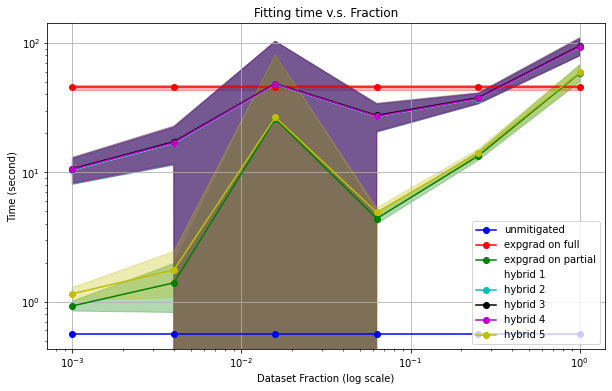

In [3]:
# Print Time and plot them
# fr = np.log10(fractions)
fr = fractions

import matplotlib
import matplotlib.pyplot as plt

n = len(time_expgrad_alls_ci)

plt.fill_between(fr, 
                 time_unmitigated_ci[:,1], 
                 time_unmitigated_ci[:,2], 
                 color='b', alpha=0.3)
plt.plot(fr, time_unmitigated_ci[:,0], 'bo-', label="unmitigated")

plt.fill_between(fr, 
                 time_expgrad_alls_ci[:,1], 
                 time_expgrad_alls_ci[:,2], 
                 color='r', alpha=0.3)
plt.plot(fr, time_expgrad_alls_ci[:,0], 'ro-', label="expgrad on full")

plt.fill_between(fr, 
                 time_expgrad_fracs_ci[:,1], 
                 time_expgrad_fracs_ci[:,2], 
                 color='g', alpha=0.3)
plt.plot(fr, time_expgrad_fracs_ci[:,0], 'go-', label="expgrad on partial")

plt.fill_between(fr, 
                 time_hybrid1_ci[:,1], 
                 time_hybrid1_ci[:,2], 
                 color='k', alpha=0.3)
plt.plot(fr, time_hybrid1_ci[:,0], 'wo-', label="hybrid 1")

plt.fill_between(fr, 
                 time_hybrid2_ci[:,1], 
                 time_hybrid2_ci[:,2], 
                 color='c', alpha=0.3)
plt.plot(fr, time_hybrid2_ci[:,0], 'co-', label="hybrid 2")

plt.fill_between(fr, 
                 time_hybrid3_ci[:,1], 
                 time_hybrid3_ci[:,2], 
                 color='k', alpha=0.3)
plt.plot(fr, time_hybrid3_ci[:,0], 'ko-', label="hybrid 3")

plt.fill_between(fr, 
                 time_hybrid4_ci[:,1], 
                 time_hybrid4_ci[:,2], 
                 color='m', alpha=0.3)
plt.plot(fr, time_hybrid4_ci[:,0], 'mo-', label="hybrid 4")

plt.fill_between(fr, 
                 time_hybrid5_ci[:,1], 
                 time_hybrid5_ci[:,2], 
                 color='y', alpha=0.3)
plt.plot(fr, time_hybrid5_ci[:,0], 'yo-', label="hybrid 5")

plt.xlabel('Dataset Fraction (log scale)')
plt.ylabel('Time (second)')
plt.title('Fitting time v.s. Fraction')
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)
plt.show()

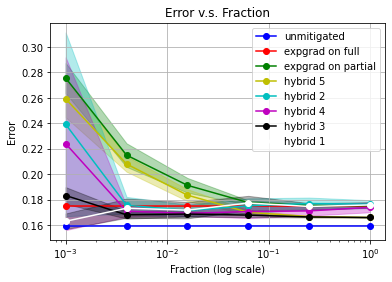

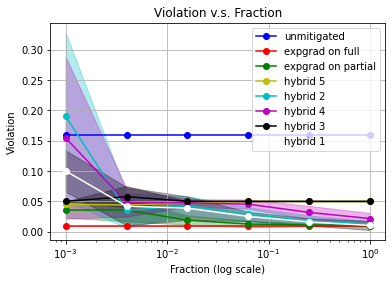

In [4]:
import matplotlib.pyplot as plt

errors = {
    "unmitigated": ("b", "bo-", "unmitigated", error_unmitigated_ci, None),
    "expgrad_alls": ("r", "ro-", "expgrad on full", error_expgrad_alls_ci, None),
    "expgrad_fracs": ("g", "go-", "expgrad on partial", error_expgrad_fracs_ci, None),
    "no_grid_rewts": ("y", "yo-", "hybrid 5", error_no_grid_rewts_ci, None),
    "grid_pmf_fracs": ("c", "co-", "hybrid 2", error_grid_pmf_fracs_ci, None),
    "rewts_partial": ("m", "mo-", "hybrid 4", error_rewts_partial_ci, None),
    "rewts_pmf": ("k", "ko-", "hybrid 3", error_rewts_pmf_ci, None),
    "hybrid_1": ("k", "wo-", "hybrid 1", error_hybrids_ci, None),
}

violations = {
    "unmitigated": ("b", "bo-", "unmitigated", vio_unmitigated_ci, None),
    "expgrad_alls": ("r", "ro-", "expgrad on full", vio_expgrad_alls_ci, None),
    "expgrad_fracs": ("g", "go-", "expgrad on partial", vio_expgrad_fracs_ci, None),
    "no_grid_rewts": ("y", "yo-", "hybrid 5", vio_no_grid_rewts_ci, None),
    "grid_pmf_fracs": ("c", "co-", "hybrid 2", vio_grid_pmf_fracs_ci, None),
    "rewts_partial": ("m", "mo-", "hybrid 4", vio_rewts_partial_ci, None),
    "rewts_pmf": ("k", "ko-", "hybrid 3", vio_rewts_pmf_ci, None),
    "hybrid_1": ("k", "wo-", "hybrid 1", vio_hybrids_ci, None),
}

# Plot errors
for k, (c1, c2, label, means, stds) in errors.items():
    plt.fill_between(fr, means[:,1], means[:,2], color=c1, alpha=0.3)
    plt.plot(fr, means[:,0], c2, label=label)
    
plt.xlabel('Fraction (log scale)')
plt.ylabel('Error')
plt.title('Error v.s. Fraction')
plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

# Plot violations
for k, (c1, c2, label, means, stds) in violations.items():
    plt.fill_between(fr, means[:,1], means[:,2], color=c1, alpha=0.3)
    plt.plot(fr, means[:,0], c2, label=label)
    
plt.xlabel('Fraction (log scale)')
plt.ylabel('Violation')
plt.title('Violation v.s. Fraction')
plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.show()